In [83]:
! pip install torch --upgrade

     |████████████████████████████████| 776.8MB 64kB/s s eta 0:00:01
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from time import time
from torch.utils.data import DataLoader

torch.__version__

'1.7.1'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
batch_size = 64

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [4]:
def accuracy(model, data_loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(data_loader):
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            predictions = scores.argmax(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    acc = num_correct / num_samples
    return acc

def train(model, data_loader, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        start_time = time()
        for batch_idx, (data, targets) in enumerate(data_loader):
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = model.loss(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'epoch {epoch}, {time() - start_time:.1f}s: {accuracy(model, data_loader):.1%}')

In [5]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.loss = nn.CrossEntropyLoss()
        self.to(device)

    def forward(self, x): # [None, 1, 28, 28]
        x = x.reshape(x.shape[0], -1) # [None, 784]
        x = F.relu(self.fc1(x)) # [None, 64]
        x = self.fc2(x) # [None, 10]
        return x

input_size = 784
num_classes = 10
learning_rate = 1e-3
num_epochs = 2

model = NN(input_size, num_classes)
train(model, train_loader, num_epochs, learning_rate)
print(f'test: {accuracy(model, test_loader):.1%}')

epoch 0, 8.9s: 93.8%
epoch 1, 8.8s: 95.6%
test: 95.2%


tensor(9)
tensor([[-5.3349, -5.1922, -6.6372, -3.0437, -0.8401,  0.7449, -5.7820, -1.4924,
         -0.2112,  4.7648]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor(9, device='cuda:0')


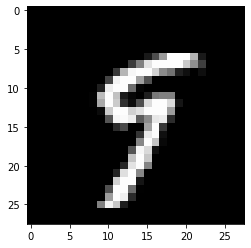

In [10]:
def check(x, y, model):
    plt.imshow(x[0, :, :], cmap='gray');
    pred = model.forward(x.to(device))
    print(y)
    print(pred)
    print(pred.argmax())
    
x, y = next(iter(train_loader))
check(x[0], y[0], model)

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        self.loss = nn.CrossEntropyLoss()
        self.to(device)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x)) # N x 120 x 1 x 1
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

lenet = LeNet()
train(lenet, train_loader, num_epochs, learning_rate)
print(f'test: {accuracy(lenet, test_loader):.1%}')

epoch 0, 11.2s: 96.6%
epoch 1, 11.2s: 97.8%
test: 97.9%


In [17]:
? nn.Conv2d

Init signature:
 nn.Conv2d(
    in_channels:int,
    out_channels:int,
    kernel_size:Union[int, Tuple[int, int]],
    stride:Union[int, Tuple[int, int]]=1,
    padding:Union[int, Tuple[int, int]]=0,
    dilation:Union[int, Tuple[int, int]]=1,
    groups:int=1,
    bias:bool=True,
    padding_mode:str='zeros',
)
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:math:`H` is a height of input planes in pixels, and :math:`W` is
w